In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from random import random
import scipy.stats
#import corner
from mpl_toolkits import mplot3d

plt.style.use('classic')

np.random.seed(2) #Número aleatorio para que los procesos se asimilen.

In [2]:
v = pd.read_csv('/home/mimimustaine/Downloads/Análisis_de_datos/stef_project/HEPData-ins1487273-v2-csv/Table5.csv')
v.head()

,$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV],$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV] LOW,$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV] HIGH,Events/(9 MeV/$c^{2}$),stat +,stat -
0,5.2045,5.200,5.209,753,27.4,-27.4
1,5.2135,5.209,5.218,704,26.5,-26.5
2,5.2225,5.218,5.227,719,26.8,-26.8
3,5.2315,5.227,5.236,680,26.1,-26.1
4,5.2405,5.236,5.245,697,26.4,-26.4


In [3]:
v.keys()

Index(['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]',
       '$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV] LOW',
       '$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV] HIGH', 'Events/(9 MeV/$c^{2}$)',
       'stat +', 'stat -'],
      dtype='object')

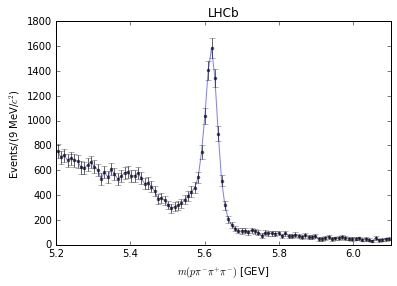

In [4]:
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], v['Events/(9 MeV/$c^{2}$)'], yerr = 2 * v['stat +'], alpha = 0.6, fmt = '.k')
plt.plot(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], v['Events/(9 MeV/$c^{2}$)'], alpha = 0.5)
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('LHCb')
plt.show()

¿Qué tal si proponemos una solución para la expresión anterior y tratamos de encontrar los parámetros de mejor ajuste?

Primero es importante identificar nuestros datos, para eso se separa en tres zonas, luego dos zonas y se realiza un ajuste, a continuación se muestran las zonas identificadas, que se ajustarán por separado y después se pensará en la unión para reproducir una función única:

#### <strong>Primera región</strong>

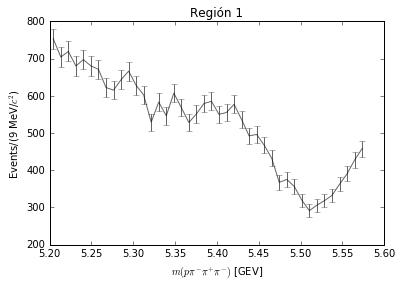

In [5]:
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:42], v['Events/(9 MeV/$c^{2}$)'][:42], yerr = v['stat +'][:42], color = 'k', alpha = 0.6)
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('Región 1')
plt.show()

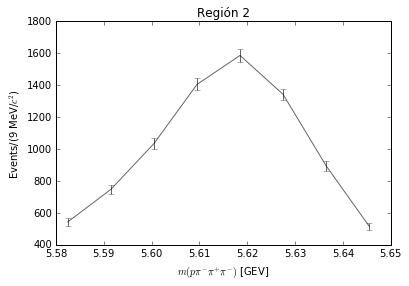

In [6]:
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][42:50], v['Events/(9 MeV/$c^{2}$)'][42:50], v['stat +'][42:50], color = 'k', alpha = 0.6)
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('Región 2')
plt.show()

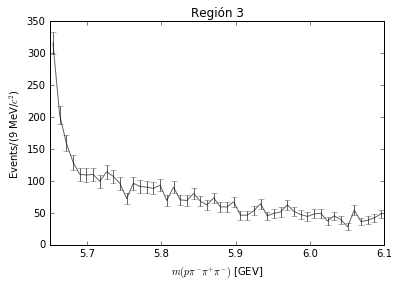

In [7]:
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][50:], v['Events/(9 MeV/$c^{2}$)'][50:], yerr = v['stat +'][50:], color = 'k', alpha = 0.6)
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('Región 3')
plt.show()

Se modelarán tres regiones: <strong>recta-gaussiana-recta</strong> y se pensará después en cómo unificar en una sola función las tres obtenidas anteriormente.

### <strong>RECTA</strong>

En esta parte nos dedicamos a la determinación de parámetros para las rectas, las funciones se hacen para cualquier recta, es importante recordar los argumentos de entrada, i. e., valor de parámetros inicial para que pueda funcionar para cualquier argumento.

Funciones que requiere <strong>Monte Carlo Markov Chain:</strong>

In [8]:
#Expresión para determinar la ecuación de la recta:
def recta(x, a, b):
    return a * x + b

#La función del logaritmo del likelihood:
def lhr(parametros, data):
    x = data[0]
    y = data[1]
    y_err = data[2]

    model = recta(x, parametros[0], parametros[1])
    chisq = (y - model) ** 2 / y_err ** 2
    return chisq.sum()

<strong>Algoritmo Monte Carlo Markov Chain:</strong>

In [12]:
def MCMC(N, caminos, sigma, v, a_ini, b_ini):
    #--------------------VALORES INICIALES--------------------#
    #Arreglos en los que se guardarán los valores iniciales, propuestos:
    a_inicial, b_inicial, lh_inicial, a, b, lh = [], [], [], [], [], []

    #Valor inicial de parámetros (a, b, lh):
    for i in range(caminos):
        a_inicial.append(np.random.normal(a_ini + (((-1) ** i) * i), sigma))
        b_inicial.append(np.random.normal(b_ini + (((-1) ** i) * i), sigma))
        #Valor inicial del likelihood:
        lh_inicial.append(lhr([a_inicial[i], b_inicial[i]], v))
        a.append([a_inicial[i]])
        b.append([b_inicial[i]])
        lh.append([lh_inicial[i]])
    #--------------------FIN VALORES INICIALES--------------------#
    
    #--------------------MONTE CARLO MARKOV CHAIN--------------------#
    #Contador para avanzar en las posiciones de valores iniciales, valor de aceptación.
    k, acep = 0, []

    for j in range(caminos):
        acep.append(0)
        for i in range(N):
            a_aux, b_aux = np.random.normal(a[j][k], sigma), np.random.normal(b[j][k], sigma)
            lh_aux = lhr([a_aux, b_aux], v)
            if lh_aux < lh_inicial[j]:
                a[j].append(a_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            else:
                comparador = - np.log(np.random.uniform(0,1)) 
                if (lh_aux - lh_inicial[j]) < comparador:
                    a[j].append(a_aux)
                    b[j].append(b_aux)
                    lh[j].append(lh_aux)
                    lh_inicial[j] = lh_aux
                    k += 1
                    acep[j] += 1
                else:
                    a[j].append(a[j][i - 1])
                    b[j].append(b[j][i - 1])
                    lh[j].append(lh_inicial[j])
                    k += 1
                
        k = 0
    
    #--------------------ACEPTACIÓN--------------------#
    for i in range(caminos):
        acep[i] /= N
    print('Aceptación:')
    print(acep)
    #--------------------FIN ACEPTACIÓN--------------------#
    #--------------------FIN MONTE CARLO MARKOV CHAIN--------------------#
    
    #--------------------CONVERGENCIA--------------------#
    plt.title('Convergencia de a, b')
    for i in range(caminos):
        plt.scatter(a[i], b[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(a[i])), alpha = 0.6)
        plt.plot(a[i], b[i], linestyle = ':', alpha = 0.6)
        plt.ylabel('b')
        plt.xlabel('a')
    plt.show()   

    l_a, l_b = [], []
    for i in range(caminos):
        l_a.append([])
        l_b.append([])
        for j in range(len(a[i])):
            l_a[i].append(j)
        for j in range(len(b[i])):
            l_b[i].append(j)
    
    for i in range(caminos):
        plt.scatter(l_a[i], a[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(a[i])), alpha = 0.6)
        plt.plot(l_a[i], a[i], linestyle = ':', alpha = 0.6)
    plt.xlabel('step')
    plt.ylabel('a')
    plt.title('Convergencia de a')
    plt.show()
    
    for i in range(caminos):
        plt.scatter(l_b[i], b[i], s = 2.0, alpha = 0.6)
        plt.plot(l_b[i], b[i], linestyle = ':', alpha = 0.6)
    plt.xlabel('step')
    plt.ylabel('b')
    plt.title('Convergencia de b')
    plt.show()

    #--------------------FIN CONVERGENCIA--------------------#
    
    #--------------------HISTOGRAMAS DE PARÁMETROS--------------------#
    a_total, b_total, total = [], [], []

    for i in range(caminos):
        for j in range(np.int(len(a[i]) / 2), len(a[i])):
            a_total.append(a[i][j])
        for j in range(np.int(len(b[i]) / 2), len(b[i])):
            b_total.append(b[i][j])
    total, name = [a_total, b_total], ['a', 'b']
    
    for i in range(len(total)):
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'step')
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'stepfilled')
        plt.axvline(np.mean(total[i]), color = 'black', label = 'Media = {0}'.format(np.round(np.mean(total[i]), 4)))
        plt.axvline(np.median(total[i]), color = 'black', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(total[i]), 4)))
        plt.xlabel('{}'.format(name[i]))
        plt.ylabel('Frecuencia')
        plt.title('Distribución para {}'.format(name[i]))
        plt.legend(frameon = True, loc = 'best')
        plt.show()
    #--------------------FIN HISTROGRAMAS DE PARÁMETROS--------------------#
    
    #--------------------RESULTADO--------------------#
    plt.errorbar(v[0], v[1], yerr = v[2], fmt='.', color = 'black')
    plt.plot(v[0], recta(v[0], np.mean(total[0]), np.mean(total[1])), alpha = 0.6, label = 'a = {}, b = {}'.format(np.round(np.median(total[0]), 4), np.round(np.median(total[1]), 4)))
    plt.legend(frameon = True, loc = 'best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Resultado')
    plt.show()
    #--------------------FIN RESULTADOS--------------------#
    
    return np.mean(total[0]), np.mean(total[1]), recta(v[0], np.mean(total[0]), np.mean(total[1]))

Aplicación a la <strong>región 1:</strong>

Aceptación:
[0.96185, 0.96635, 0.96045, 0.9611, 0.9552]


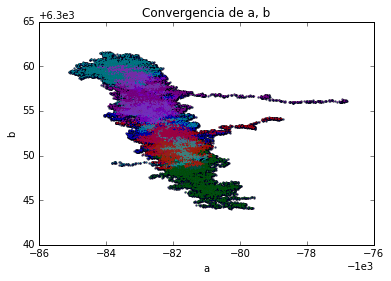

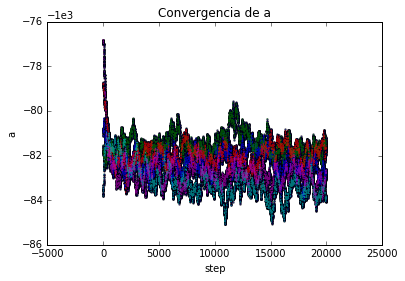

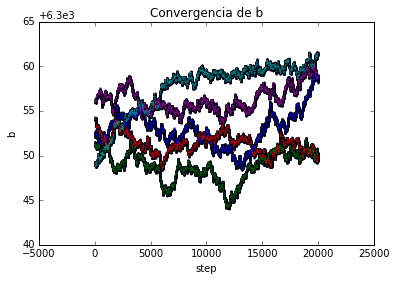

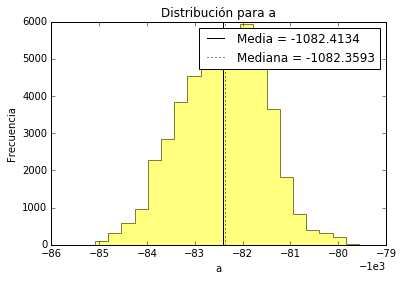

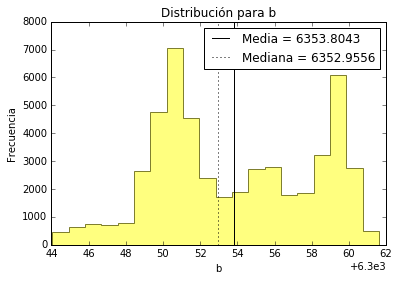

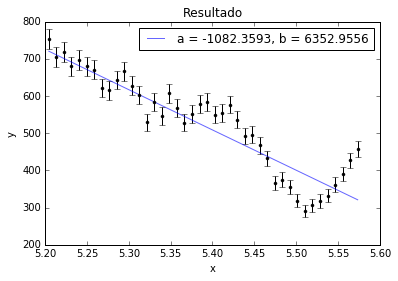

In [17]:
#Argumentos: N, caminos, sigma, v, a_ini, b_ini, x_min, x_max
a1, b1, y1 = MCMC(20000, 5, 0.05, [v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:42], v['Events/(9 MeV/$c^{2}$)'][:42], v['stat +'][:42]], -1080.80, 6352.13)

Aplicación a la <strong>región 3:</strong>

Aceptación:
[0.88485, 0.8824, 0.88295, 0.87835, 0.87895]


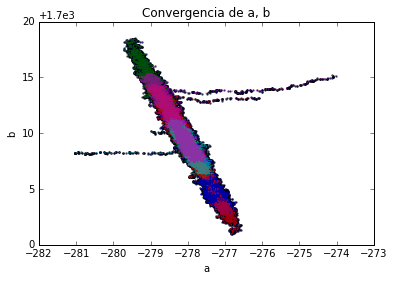

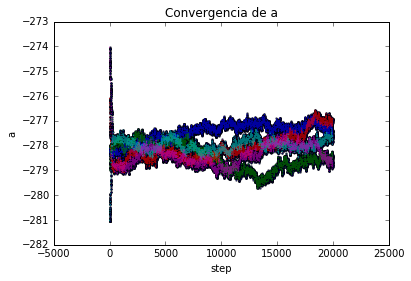

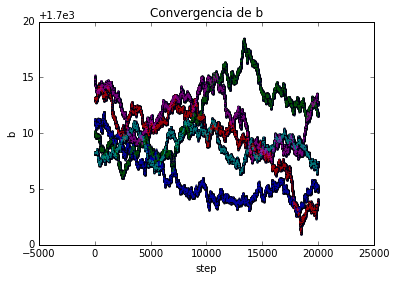

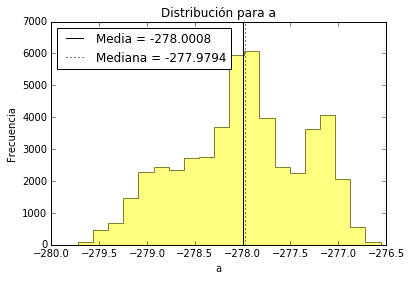

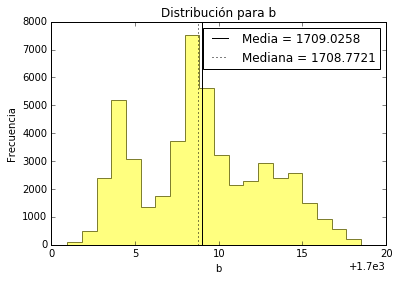

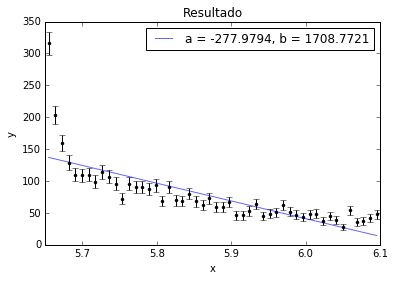

In [19]:
#Argumentos: N, caminos, sigma, v, a_ini, b_ini, x_min, x_max
a3, b3, y3 = MCMC(20000, 5, 0.05, [v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][50:], v['Events/(9 MeV/$c^{2}$)'][50:], v['stat +'][50:]], -278.09, 1711.2)

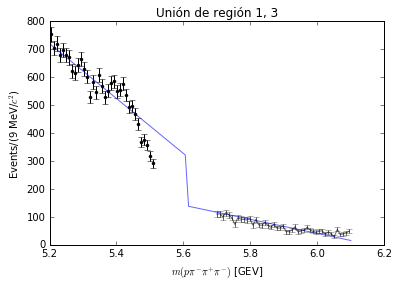

In [20]:
plt.plot(np.linspace(5.2, 6.1, len(np.concatenate([y1, y3]))), np.concatenate([y1, y3]), alpha = 0.6)
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35], v['Events/(9 MeV/$c^{2}$)'][:35], yerr = v['stat +'][:35], fmt='.', color = 'black')
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:], v['Events/(9 MeV/$c^{2}$)'][55:], yerr = v['stat +'][55:], color = 'k', alpha = 0.6)
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('Unión de región 1, 3')
plt.show()

### <strong>GAUSSIANA</strong>

Para esta parte se consideran parámetros de entrada en la función <strong>gauss</strong> más una constante como traslación en el eje y, el algoritmo se muestra a continuación:

In [64]:
#Expresión para determinar la ecuación de la recta:
def gauss(x, mu, s, amp):
    return amp * (1 / (np.sqrt(2 * np.pi * s ** 2))) * np.exp(- (x - mu) ** 2 / (2 * s ** 2))

#La función del logaritmo del likelihood:
def lhg(parametros, data):
    x = data[0]
    y = data[1]
    y_err = data[2]

    model = gauss(x, parametros[0], parametros[1], parametros[2])
    chisq = (y - model) ** 2 / y_err ** 2
    return chisq.sum()

#Se requiere de un prior debido a que los valores no tienden a los esperados.
def priorg(mu, s, b):
    if((mu > 5.60 and mu < 5.62) and (s > 0.0206 and s < 0.021) and (b > 0.0 and b < 100.0)):
        return 0.0
    else:
        return np.inf

In [44]:
def MCMC(N, caminos, sigma, v, mu_ini, s_ini, b_ini, h):
    #--------------------VALORES INICIALES--------------------#
    #Arreglos en los que se guardarán los valores iniciales, propuestos:
    mu_inicial, s_inicial, lh_inicial, b_inicial, mu, s, b, lh = [], [], [], [], [], [], [], []

    #Valor inicial de parámetros (a, b, lh):
    for i in range(caminos):
        mu_inicial.append(np.random.normal(mu_ini, sigma))
        s_inicial.append(np.random.normal(s_ini, sigma))
        b_inicial.append(np.random.normal(b_ini, sigma))
        #Valor inicial del likelihood:
        lh_inicial.append(lhr([mu_inicial[i], s_inicial[i], b_inicial[i]], v))
        mu.append([mu_inicial[i]])
        s.append([s_inicial[i]])
        b.append([b_inicial[i]])
        lh.append([lh_inicial[i]])
    #--------------------FIN VALORES INICIALES--------------------#
    
    #--------------------MONTE CARLO MARKOV CHAIN--------------------#
    #Contador para avanzar en las posiciones de valores iniciales, valor de aceptación.
    k, acep = 0, []

    for j in range(caminos):
        acep.append(0)
        for i in range(N):
            mu_aux, s_aux, b_aux = np.random.normal(mu[j][k], sigma), np.random.normal(s[j][k], sigma), np.random.normal(b[j][k], sigma)
            
            proof = priorg(mu_aux, s_aux, b_aux)
            
            if proof != 0:
                lh_aux = proof
            else:
                lh_aux = lhr([mu_aux, s_aux, b_aux], v)
            
            if lh_aux < lh_inicial[j]:
                mu[j].append(mu_aux)
                s[j].append(s_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            else:
                comparador = - np.log(np.random.uniform(0,1)) 
                if (lh_aux - lh_inicial[j]) < comparador:
                    mu[j].append(mu_aux)
                    s[j].append(s_aux)
                    b[j].append(b_aux)
                    lh[j].append(lh_aux)
                    lh_inicial[j] = lh_aux
                    k += 1
                    acep[j] += 1
                else:
                    mu[j].append(mu[j][i - 1])
                    s[j].append(s[j][i - 1])
                    b[j].append(b[j][i - 1])
                    lh[j].append(lh_inicial[j])
                    k += 1
                
        k = 0
    
    #--------------------ACEPTACIÓN--------------------#
    for i in range(caminos):
        acep[i] /= N
    print('Aceptación:')
    print(acep)
    #--------------------FIN ACEPTACIÓN--------------------#
    #--------------------FIN MONTE CARLO MARKOV CHAIN--------------------#
    
    #--------------------CONVERGENCIA--------------------#
    plt.title('Convergencia de $\\mu$, $\\sigma$')
    for i in range(caminos):
        plt.scatter(mu[i], s[i], s = 2.0, alpha = 0.5)
        plt.plot(mu[i], s[i], linestyle = ':', alpha = 0.5)
        plt.ylabel('$\\sigma$')
        plt.xlabel('$\\mu$')
    plt.show()   

    l_mu, l_s = [], []
    for i in range(caminos):
        l_mu.append([])
        l_s.append([])
        for j in range(len(mu[i])):
            l_mu[i].append(j)
        for j in range(len(s[i])):
            l_s[i].append(j)
    
    for i in range(caminos):
        plt.scatter(l_mu[i], mu[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(mu[i])), alpha = 0.5)
        plt.plot(l_mu[i], mu[i], linestyle = ':', alpha = 0.5)
    plt.xlabel('step')
    plt.ylabel('$\\mu$')
    plt.title('Convergencia de $\\mu$')
    plt.show()
    
    for i in range(caminos):
        plt.scatter(l_s[i], s[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(s[i])),alpha = 0.5)
        plt.plot(l_s[i], s[i], linestyle = ':', alpha = 0.5)
    plt.xlabel('step')
    plt.ylabel('$\\sigma$')
    plt.title('Convergencia de $\\sigma$')
    plt.show()

    #--------------------FIN CONVERGENCIA--------------------#
    
    #--------------------HISTOGRAMAS DE PARÁMETROS--------------------#
    mu_total, s_total, b_total, total = [], [], [], []

    for i in range(caminos):
        for j in range(np.int(len(mu[i]) / 2), len(mu[i])):
            mu_total.append(mu[i][j])
        for j in range(np.int(len(s[i]) / 2), len(s[i])):
            s_total.append(s[i][j])
        for j in range(np.int(len(b[i]) / 2), len(b[i])):
            b_total.append(b[i][j])
    total, name = [mu_total, s_total, b_total], ['$\\mu$', '$\\sigma$', 'b']
    
    for i in range(len(total)):
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'stepfilled')
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'step')
        plt.axvline(np.mean(total[i]), color = 'black', label = 'Media = {0}'.format(np.round(np.mean(total[i]), 4)))
        plt.axvline(np.median(total[i]), color = 'black', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(total[i]), 4)))
        plt.xlabel('{}'.format(name[i]))
        plt.ylabel('Frecuencia')
        plt.title('Distribución para {}'.format(name[i]))
        plt.legend(frameon = True, loc = 'best')
        plt.show()
    #--------------------FIN HISTROGRAMAS DE PARÁMETROS--------------------#
    
    #--------------------RESULTADO--------------------#
    y = gauss(v[0], np.mean(total[0]), np.mean(total[1]), np.mean(total[2])) + h
    plt.errorbar(v[0], v[1], yerr = v[2], fmt='.', color = 'black', alpha = 0.5)
    #plt.show()
    plt.plot(v[0], y, alpha = 0.5, label = '$\\mu$ = {}, $\\sigma$ = {}, b = {}'.format(np.round(np.mean(total[0]), 4), np.round(np.mean(total[1]), 4), np.round(np.mean(total[2]), 4)))
    plt.legend(frameon = True, loc = 'best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Resultado')
    plt.show()
    #--------------------FIN RESULTADOS--------------------#
    
    return np.mean(total[0]), np.mean(total[1]), np.mean(total[2]), gauss(v[0], np.mean(total[0]), np.mean(total[1]), np.mean(total[2])) + h

Aceptación:
[0.01524, 0.01468, 0.01534, 0.01662, 0.01654]


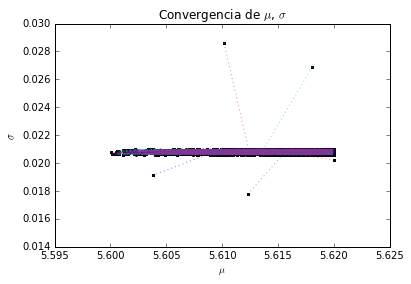

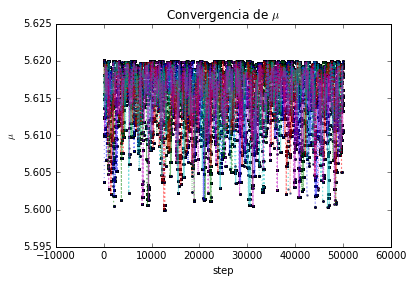

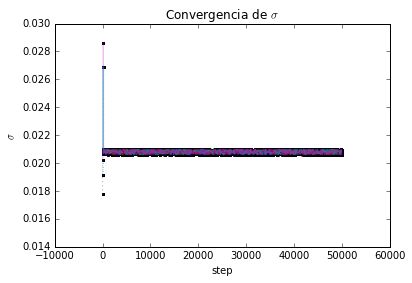

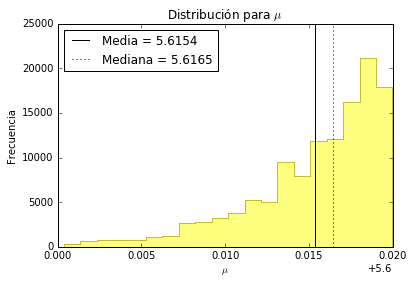

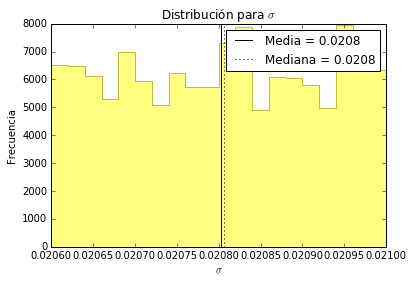

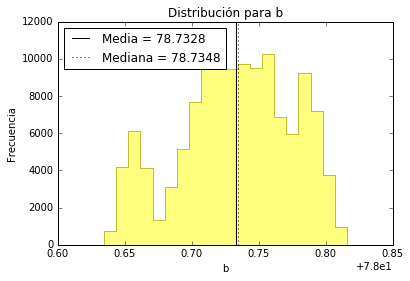

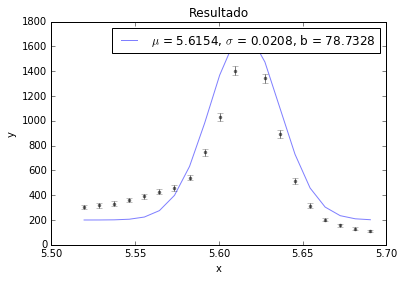

In [65]:
mu, sig, amp, y2 = MCMC(50000, 5, 0.005, [v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][35:55], v['Events/(9 MeV/$c^{2}$)'][35:55], v['stat +'][35:55]], 5.616, 2.078 * 10 ** -2, 7.875 * 10 ** 1, 200)

Se muestra a continuación la unión de las funciones que componen al modelo:

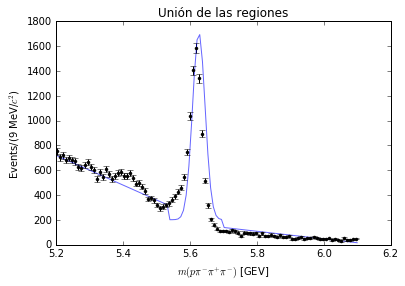

In [66]:
plt.plot(np.linspace(5.2, 6.1, len(np.concatenate([y1, y2, y3]))), np.concatenate([y1, y2, y3]), alpha = 0.6)
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], v['Events/(9 MeV/$c^{2}$)'], yerr = v['stat +'], fmt='.', color = 'black')
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.title('Unión de las regiones')
plt.savefig('Prueba.png')
plt.show()

### <strong>Valores iniciales, finales</strong>

Los <strong>valores iniciales</strong> de los parámetros se obtuvieron por medio de la función <strong>curve_fit</strong> de la librería <strong>scipy.optimize</strong>. A continuación se muestran los valores iniciales obtenidos y los obtenidos con <strong>Monte Carlo Markov Chain:</strong>

In [10]:
from scipy.optimize import curve_fit

<strong>Región 1</strong>

curve_fit:

In [11]:
curve_fit(recta, v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:42], v['Events/(9 MeV/$c^{2}$)'][:42])

(array([-1080.80563406,  6352.1282286 ]),
 array([[  5120.25608257, -27593.06023635],
        [-27593.06023635, 148759.93505078]]))

MCMC:

In [14]:
a1, b1

(-1082.5433678773754, 6351.297911208421)

<strong>Región 2</strong>

curve_fit:

In [24]:
curve_fit(gauss, v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][42:50], v['Events/(9 MeV/$c^{2}$)'][42:50])

(array([5.61609458e+00, 2.07812760e-02, 7.87589423e+01]),
 array([[8.83620659e-07, 6.91430554e-08, 1.75744420e-04],
        [6.91430554e-08, 1.22539186e-06, 2.54965891e-03],
        [1.75744420e-04, 2.54965891e-03, 1.10104822e+01]]))

MCMC:

In [67]:
mu, sig, amp

(5.615395695726023, 0.020802921486256523, 78.73277673628473)

<strong>Región 3</strong>

curve_fit:

In [15]:
curve_fit(recta, v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][50:], v['Events/(9 MeV/$c^{2}$)'][50:])

(array([-278.08990255, 1711.19817746]),
 array([[ 1184.2199264 , -6957.29208035],
        [-6957.29208035, 40894.06676485]]))

MCMC:

In [21]:
a3, b3

(-278.0007954026893, 1709.0258414163666)

### <strong>Unión</strong>

La unión de las funciones que puede representarse de dos maneras diferentes, la primera consta de unir las funciones que componen la función, de tal forma que:

\begin{equation}
     \label{eq:aqui-le-mostramos-como-hacerle-la-llave-grande}
     f(x) = \left\{
	       \begin{array}{ll}
		 a_{1}x + b_{1}      & \mathrm{si\ } x < 5.5195 \\
		 \dfrac{1}{\sqrt{2\pi \sigma^{2}}}e^{(x - \mu)^{2}/2\sigma^{2}} & \mathrm{si\ } 5.5195 \le x \le 5.6995 \\
		 a_{3}x + b_{3}    & \mathrm{si\ } x > 5.6995
	       \end{array}
	     \right.
   \end{equation}

Función en la que se conjuntan las características de los datos presetados anteriormente:

In [70]:
def suma(x, h):
    y1, y2, y3 = [], [], []
    y1 = recta(x[x < 5.5195], a1, b1)
    y3 = recta(x[x > 5.6995], a3, b3)
    y2 = gauss(x[(x >= 5.5195) & (x <= 5.6995)], mu, sig, amp) + h
    #y2 = np.exp((x[x >= 5.5195 and x <= 5.6995] - mu) ** 2 / (2 * sig ** 2)) / (np.sqrrt)
    y1, y2, y3 = np.array(y1), np.array(y2), np.array(y3)
    return np.concatenate([y1, y2, y3])

El resultado obtenido con la <strong>regresión lineal-gaussiana-lineal</strong> es el siguiente:

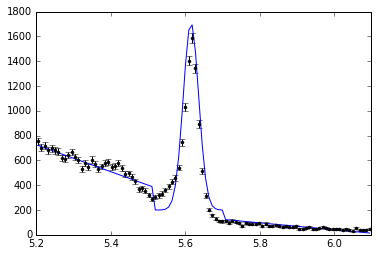

In [71]:
plt.errorbar(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], v['Events/(9 MeV/$c^{2}$)'], yerr = v['stat +'], fmt='.', color = 'black')
plt.plot(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], suma(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'], 200))

### <strong>Notas:</strong>

<ul>
    <li> Se requiere un gran número de iteraciones para hacer converger a los parámetros al valor esperado.</li>
    <li> Se usó la librería <strong>scipy</strong> para tener una referencia de valores iniciales en los parámetros.</li>
    <li> Es necesario el uso de un <strong>prior</strong> para poder acotar la región en la que se busca el valor del parámetro, se observó que en el caso de la gaussiana, el valor de los parámetros divergía lejos de la región requerida, fue aquí donde se incluyó el prior y además se varió $\sigma$ para obtener un valor buscado.</li>
    <li> Se hizo uso de una traslación en el eje y después de que se adaptaran los puntos a la zona deseada cuidando que sólo se hiciera en la zona requerida, no a lo largo de toda la función.</li>
    <li> El resultado podría compararse con MCMC en librerías de <strong>Python</strong> tales como <strong>Multinest.</strong> </li>
    <li> Los valores obtenidos son muy parecidos a los que se obtienen con <strong>scipy</strong> </li>
</ul>

### Se podría probar con una <strong>exponencial-gaussiana...</strong>

Con este método se trata de probar con una función <strong>exponencial</strong> con los datos que no correspondan al área de la <strong>gaussiana.</strong> Se propone hacer uso de lo siguiente:

In [85]:
#Expresión para determinar la ecuación de la recta:
def exponencial(x, amp, b):
    return amp * np.exp(b * x)

#La función del logaritmo del likelihood:
def lhg(parametros, data):
    x = data[0]
    y = data[1]
    y_err = data[2]

    model = exponencial(x, parametros[0], parametros[1], parametros[2])
    chisq = (y - model) ** 2 / y_err ** 2
    return chisq.sum()

#Se requiere de un prior debido a que los valores no tienden a los esperados.
def priorg(mu, b):
    if((mu > 6.330005 * 10 ** 9 and mu < 6.340005 * 10 ** 9) and (b < -2.95 and b > -3.10)):
        return 0.0
    else:
        return np.inf

In [81]:
def MCMC(N, caminos, sigma, v, amp_ini, b_ini):
    #--------------------VALORES INICIALES--------------------#
    #Arreglos en los que se guardarán los valores iniciales, propuestos:
    amp_inicial, b_inicial, lh_inicial, amp, b, lh = [], [], [], [], [], []

    #Valor inicial de parámetros (a, b, lh):
    for i in range(caminos):
        amp_inicial.append(np.random.normal(amp_ini, sigma))
        b_inicial.append(np.random.normal(b_ini, sigma))
        #Valor inicial del likelihood:
        lh_inicial.append(lhr([amp_inicial[i], b_inicial[i]], v))
        amp.append([amp_inicial[i]])
        b.append([b_inicial[i]])
        lh.append([lh_inicial[i]])
    #--------------------FIN VALORES INICIALES--------------------#
    
    #--------------------MONTE CARLO MARKOV CHAIN--------------------#
    #Contador para avanzar en las posiciones de valores iniciales, valor de aceptación.
    k, acep = 0, []

    for j in range(caminos):
        acep.append(0)
        for i in range(N):
            amp_aux, b_aux = np.random.normal(amp[j][k], sigma), np.random.normal(b[j][k], sigma)
            
            proof = priorg(amp_aux, b_aux)
            
            if proof != 0:
                lh_aux = proof
            else:
                lh_aux = lhr([amp_aux, b_aux], v)
            
            if lh_aux < lh_inicial[j]:
                amp[j].append(amp_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            else:
                comparador = - np.log(np.random.uniform(0,1)) 
                if (lh_aux - lh_inicial[j]) < comparador:
                    amp[j].append(amp_aux)
                    b[j].append(b_aux)
                    lh[j].append(lh_aux)
                    lh_inicial[j] = lh_aux
                    k += 1
                    acep[j] += 1
                else:
                    amp[j].append(amp[j][i - 1])
                    b[j].append(b[j][i - 1])
                    lh[j].append(lh_inicial[j])
                    k += 1
                
        k = 0
    
    #--------------------ACEPTACIÓN--------------------#
    for i in range(caminos):
        acep[i] /= N
    print('Aceptación:')
    print(acep)
    #--------------------FIN ACEPTACIÓN--------------------#
    #--------------------FIN MONTE CARLO MARKOV CHAIN--------------------#
    
    #--------------------CONVERGENCIA--------------------#
    plt.title('Convergencia de amp, b')
    for i in range(caminos):
        plt.scatter(amp[i], b[i], s = 2.0, alpha = 0.5)
        plt.plot(amp[i], b[i], linestyle = ':', alpha = 0.5)
        plt.ylabel('b')
        plt.xlabel('amp')
    plt.show()   

    l_amp, l_b = [], []
    for i in range(caminos):
        l_amp.append([])
        l_b.append([])
        for j in range(len(amp[i])):
            l_amp[i].append(j)
        for j in range(len(b[i])):
            l_b[i].append(j)
    
    for i in range(caminos):
        plt.scatter(l_amp[i], amp[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(amp[i])), alpha = 0.5)
        plt.plot(l_amp[i], amp[i], linestyle = ':', alpha = 0.5)
    plt.xlabel('step')
    plt.ylabel('amp')
    plt.title('Convergencia de amp')
    plt.show()
    
    for i in range(caminos):
        plt.scatter(l_b[i], b[i], s = 2.0, label = 'Iteraciones = {0}'.format(len(b[i])),alpha = 0.5)
        plt.plot(l_b[i], b[i], linestyle = ':', alpha = 0.5)
    plt.xlabel('step')
    plt.ylabel('b')
    plt.title('Convergencia de b')
    plt.show()

    #--------------------FIN CONVERGENCIA--------------------#
    
    #--------------------HISTOGRAMAS DE PARÁMETROS--------------------#
    amp_total, b_total, total = [], [], []

    for i in range(caminos):
        for j in range(np.int(len(amp[i]) / 2), len(amp[i])):
            amp_total.append(amp[i][j])
        for j in range(np.int(len(b[i]) / 2), len(b[i])):
            b_total.append(b[i][j])
    total, name = [amp_total, b_total], ['amp', 'b']
    
    for i in range(len(total)):
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'stepfilled')
        plt.hist(total[i], 20, color = 'yellow', alpha = 0.5, histtype = 'step')
        plt.axvline(np.mean(total[i]), color = 'black', label = 'Media = {0}'.format(np.round(np.mean(total[i]), 4)))
        plt.axvline(np.median(total[i]), color = 'black', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(total[i]), 4)))
        plt.xlabel('{}'.format(name[i]))
        plt.ylabel('Frecuencia')
        plt.title('Distribución para {}'.format(name[i]))
        plt.legend(frameon = True, loc = 'best')
        plt.show()
    #--------------------FIN HISTROGRAMAS DE PARÁMETROS--------------------#
    
    #--------------------RESULTADO--------------------#
    plt.errorbar(v[0], v[1], yerr = v[2], fmt='.', color = 'black', alpha = 0.5)
    #plt.show()
    plt.plot(v[0], exponencial(v[0], np.mean(total[0]), np.mean(total[1])), alpha = 0.5, label = '$\\mu$ = {}, b = {}'.format(np.round(np.mean(total[0]), 4), np.round(np.mean(total[1]), 4)))
    plt.legend(frameon = True, loc = 'best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Resultado')
    plt.show()
    #--------------------FIN RESULTADOS--------------------#
    
    return np.mean(total[0]), np.mean(total[1]), exponencial(v[0], np.mean(total[0]), np.mean(total[1]))

Aceptación:
[0.28316, 0.28354, 0.28166, 0.28324, 0.28188]


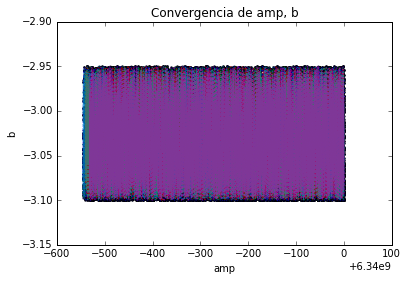

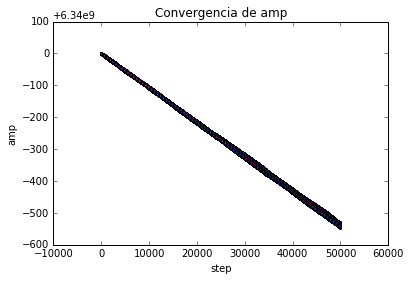

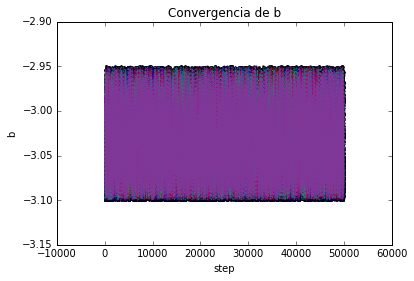

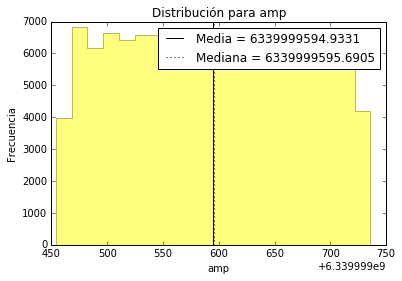

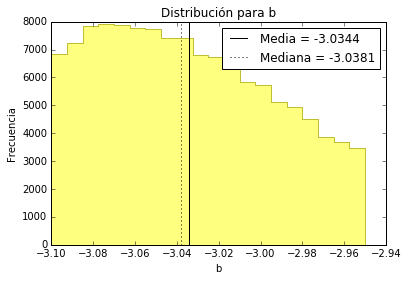

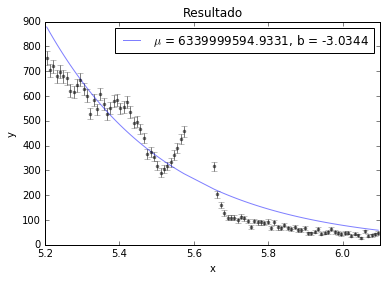

In [86]:
ampe, be, y2 = MCMC(50000, 5, 0.05, [np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:42]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][50:])]), np.concatenate([np.array(v['Events/(9 MeV/$c^{2}$)'][:42]), np.array(v['Events/(9 MeV/$c^{2}$)'][50:])]), np.concatenate([np.array(v['stat +'][:42]), np.array(v['stat +'][50:])])], 6.34 * 10 ** 9, -3.045)

### <strong>Valores iniciales</strong>

curve_fit:

In [78]:
curve_fit(exponencial, np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:42]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][50:])]), np.concatenate([np.array(v['Events/(9 MeV/$c^{2}$)'][:42]), np.array(v['Events/(9 MeV/$c^{2}$)'][50:])]))

(array([ 6.34112011e+09, -3.04497145e+00]),
 array([[ 1.66625408e+19, -4.90593479e+08],
        [-4.90593479e+08,  1.44555881e-02]]))

MCMC:

In [87]:
ampe, be

(6339999594.933141, -3.034350895189019)

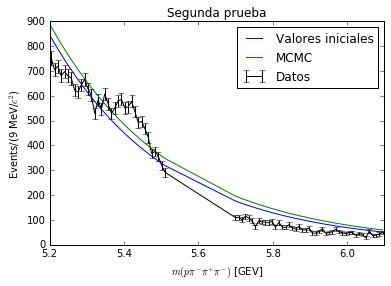

In [88]:
plt.plot(np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:])]), exponencial(np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:])]), 1.1 * 10 ** 10, -3.15), label = 'Valores iniciales')
plt.plot(np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:])]), exponencial(np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:])]), ampe, be), label = 'MCMC')
plt.errorbar(np.concatenate([np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][:35]), np.array(v['$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]'][55:])]), np.concatenate([np.array(v['Events/(9 MeV/$c^{2}$)'][:35]), np.array(v['Events/(9 MeV/$c^{2}$)'][55:])]), yerr = np.concatenate([v['stat +'][:35], v['stat +'][55:]]), label = 'Datos', color = 'black')
plt.xlabel('$m(p\pi^{-}\pi^{+}\pi^{-})$ [GEV]')
plt.ylabel('Events/(9 MeV/$c^{2}$)')
plt.legend(frameon = True, loc = 'best')
plt.title('Segunda prueba')
plt.show()

### <strong>Notas:</strong>

<ul>
    <li>Lo que se observa con este modelo es que la zona de convergencia para uno de los parámetros es <strong>inestable</strong> en el sentido de que el valor del parámetro sigue decreciendo, podría seguir haciéndolo si el prior no estuviera presente, además de que no es muy confiable porque se nota que la curva no toca más de uno de los puntos que conforman los datos, y no sólo eso, no se traslapa con algunas de las barras de error, no podríamos que es consistente con la información presentada.</li>
</ul>

### <strong>Notas generales:</strong>

<ul>
    <li>El modelo podría hacerse más eficiente si se consideraran en diferentes zonas polinomios y no sólo rectas, eso "complica" el algoritmo pues trata de un número mayor de entradas, y no sólo eso, mayor tiempo de ejecución. Podría complementarse para comparar el qué tan bueno es respecto al que se tiene anteriormente.</li>
    <li>Se hizo uso de una traslación en el eje y para el área de corresponde a la gaussiana porque esta función $f: f \to 0$ cuando $x \to \infty, x \to - \infty$, por lo que se traslado únicamente algunas unidades por encima del eje y, este parámetro no se ajustó puesto que hubo problemas a la hora de hacer la regresión, no se ejecutaba correctamente la acción. Por este motivo, el algoritmo podría mejorarse considerando también a este parámetro llamado <strong>h.</strong> </li>
</ul>

### <strong>REFERENCIAS</strong>

[1] The LHCb collaboration. <strong>Measurement of matter–antimatter differences inbeauty baryon decays.</strong> Nature Physics. https://www.nature.com/articles/nphys4021.pdf

[2] The LHCb collaboration. HEPData : https://www.hepdata.net/record/76921?version=2

[3] Javier Duarte. <strong>CMS OPEN DATAFORMACHINE LEARNING - JET DATASET.</strong> DATA SCIENCE @ HIGH ENERGY PHYSICS 2017. Fermilab. BATAVIA, IL, USA. https://indico.fnal.gov/event/13497/session/6/contribution/54/material/slides/0.pdf

[4] <strong>Introduction to Scipy: Fitting data.</strong> https://astrofrog.github.io/py4sci/_static/15.%20Fitting%20models%20to%20data.html

[5] Martin Haugh. <strong>MCMC and Bayesian Modeling.</strong> Columbia University. 2017. http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf

[6] David A. van Dyk. <strong>Markov Chain Monte Carlo.</strong> Statistics Section, Imperial College London Smithsonian Astrophysical Observatory, March 2014. https://hea-www.harvard.edu/AstroStat/Stat310_1314/dvd_20140328.pdf 